In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.ndimage import uniform_filter1d
from pycbc import psd as psd_func
from pycbc.filter.matchedfilter import sigma, overlap_cplx
from pycbc.types import FrequencySeries
from simple_pe.waveforms import make_waveform

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Testing

Below is the old unweighted orthogonalisation method.

In [2]:
def old_ortho(h, ifo_psd, f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1]):

    # Ensure modes in ortho_list are orthogonalized first
    modes = np.concatenate((ortho_list, modes))
    modes = list(dict.fromkeys(modes))

    sigmas = {}
    for mode in modes:

        try:
            sigmas[mode] = sigma(
                h[mode], ifo_psd, low_frequency_cutoff=f_low,
                high_frequency_cutoff=ifo_psd.sample_frequencies[-1]
                )
            h[mode] /= sigmas[mode]
        except ZeroDivisionError:
            print("No power in mode %s" % mode)
            h.pop(mode)

    zetas = {ortho_list[0]: 1}
    h_perp = {}
    for mode in modes:
        h_perp[mode] = h[mode]
        for ortho_mode in ortho_list:
            if mode == ortho_mode:
                break
            zeta = overlap_cplx(
                h_perp[ortho_mode], h_perp[mode], psd=ifo_psd,
                low_frequency_cutoff=f_low,
                high_frequency_cutoff=ifo_psd.sample_frequencies[-1],
                normalized=True
                )

            # generate the orthogonal waveform
            h_perp[mode] = (h_perp[mode] - zeta * h_perp[ortho_mode]) / \
                           (np.sqrt(1 - np.abs(zeta) ** 2))

            if ortho_mode == ortho_list[0]:
                zetas[mode] = zeta

    return h_perp, sigmas, zetas

This does give orthogonalised harmonics, however implicitly assumes that the overlap between the waveforms is independent of frequency. I believe however that the overlap does depend on frequency, being greatest around merger. This would therefore mean that this method actually introduces power from higher harmonics at earlier frequencies, and does not remove enough power at merger frequencies.

We therefore want to weight the subtraction of the higher modes with some weights which describe the contribution to the overlap at different frequencies. As long as these integrate to one with the correct normalisation, this should still lead to orthogonal harmonics.

The naive idea is to simply remove the integral from the overlap equation below in order to use the integrand as weights. This does not work however - at any given frequency the integrand for two orthogonal waveforms is not necessarily zero, but instead averages to zero over all frequencies.

$$
(a|b) = 4\int_{f_\mathrm{low}}^{f_\mathrm{high}}\frac{\tilde{a}(f)\tilde{b}^*(f)}{S(f)}df.
$$

We also do not want to weight by the PSD ($S(f)$) when calculating our weights.

The next idea is therefore to split the frequency range into frequency bins, and calculate the overlap over each one with no PSD (or alternatively uniform PSD). We can then interpolate to all frequencies and estimate the weights as such. We need sufficient points in each frequency bin for the random contributions from unorthogonal harmonics to be expected to average to zero, and so the range of frequencies will therefore be dependent of $\Delta f$, and therefore on the signal length in the time domain.

Let's have a look at this now.

In [81]:
# Generate harmonics
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/32, 10, (32*4096)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)

# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

In [50]:
# Calculate weights at each frequency bin (for orthogonalisation with dominant harmonic only)
freq_bin_size = 16
weights = {}
freqs = np.arange(0, psds['f_high'], freq_bin_size) + freq_bin_size/2
for k in [-1,1,2]:
    weights[k] = []
    for i, f in enumerate(freqs):
        ovlp = overlap_cplx(
            harms[0], harms[k], normalized=True,
            low_frequency_cutoff=(f-freq_bin_size/2),
            high_frequency_cutoff=(f+freq_bin_size/2)
        )
        weights[k].append(ovlp)

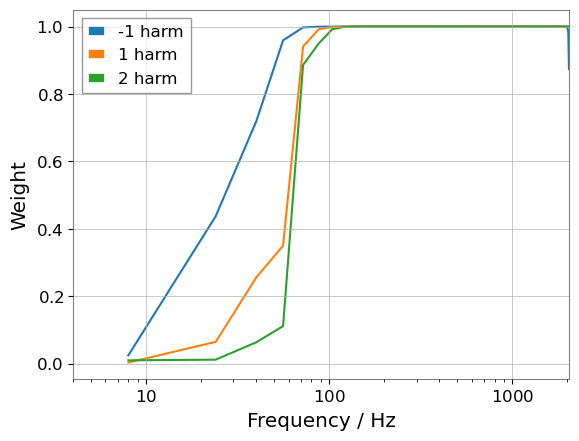

In [53]:
# Plot calculated weights
for k in weights.keys():
    plt.plot(freqs, np.abs(weights[k]), label=f'{k} harm')
plt.legend()
# plt.ylim(0,1)
plt.xlim(freqs[0]/2, psds['f_high'])
plt.xscale('log')
plt.xlabel('Frequency / Hz')
plt.ylabel('Weight')
plt.show()

It is clear that all the weights of all harmonics go to 1 at $\sim 100 Hz$. This therefore suggests that all harmonics are the same above this frequency. We see that the weights are generally lower for the higher harmonics - this makes sense as merger occurs at higher frequencies for them.

For this particular signal, frequency bins of 16Hz seem to work the best. This corresponds to $16 \times 32 = 512$ datapoints. See that for both lower and higher mass, 16Hz bins also seems to be a good spot, so we may be able to use this regardless of the signal length.

Let's try using a rolling average rather than strict bins. This will require us to perform the overlap calculation ourselves rather than using the in-built pycbc functionality, but will hopefully get rid of the sharp corners we see here.

In [90]:
# Calculate weights at rolling frequency bin (for orthogonalisation with dominant harmonic only)
freq_bin_size = 16
N = int(16/harms[0].delta_f)+1
weights = {}
for k in [-1,1,2]:
    ovlp_series = harms[0].data.conj() * harms[k]
    norm_series0sqrd = np.abs(harms[0].data.conj() * harms[0])
    norm_seriesksqrd = np.abs(harms[k].data.conj() * harms[k])
    ovlp_series = np.convolve(ovlp_series, np.ones(N), mode='same')
    norm_series0 = np.sqrt(np.convolve(norm_series0sqrd, np.ones(N), mode='same'))
    norm_seriesk = np.sqrt(np.convolve(norm_seriesksqrd, np.ones(N), mode='same'))
    norm = 1 / norm_series0 / norm_seriesk
    weights[k] = ovlp_series * norm

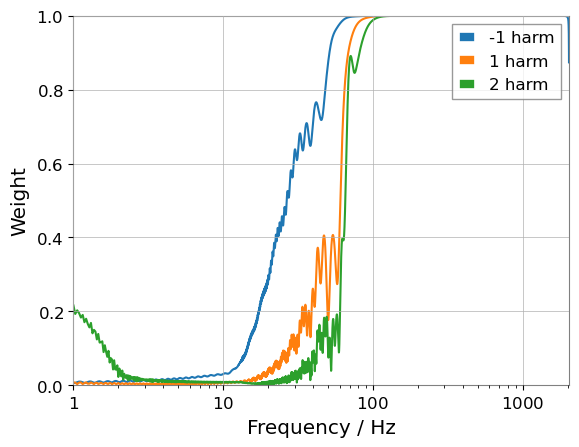

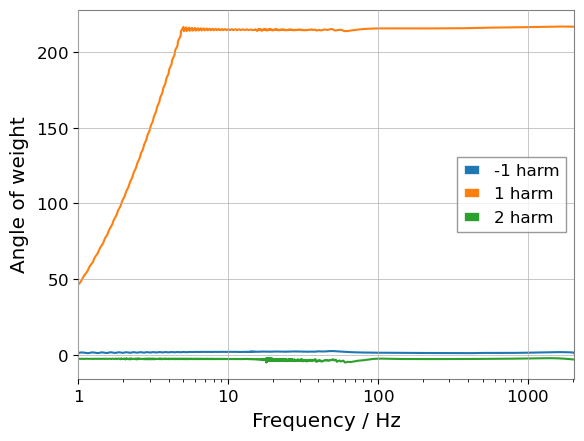

In [94]:
# Plot calculated weights
fs = harms[0].sample_frequencies[N//2:-(N//2)]
for k in weights.keys():
    plt.plot(harms[0].sample_frequencies, np.abs(weights[k]), label=f'{k} harm')
plt.legend()
plt.ylim(0,1)
plt.xlim(1, harms[0].sample_frequencies[-1])
plt.xscale('log')
plt.xlabel('Frequency / Hz')
plt.ylabel('Weight')
plt.show()

# Plot angle of weights
for k in weights.keys():
    angs = np.angle(weights[k])
    ang_diffs = np.diff(angs)
    ang_diffs[ang_diffs>np.pi] -= 2*np.pi
    ang_diffs[ang_diffs<-np.pi] += 2*np.pi
    ang_diffs = np.insert(ang_diffs, 0, angs[0])
    angs = np.cumsum(ang_diffs)
    plt.plot(harms[0].sample_frequencies, angs, label=f'{k} harm')
plt.legend()
plt.xlim(1, harms[0].sample_frequencies[-1])
plt.xscale('log')
plt.xlabel('Frequency / Hz')
plt.ylabel('Angle of weight')
plt.show()

This looks pretty good, and let's us calculate weights at all frequencies.

Now trying 3x3 grid of eccentricities and masses.

Calculated e_10 = 0.05, chirp = 10.
Calculated e_10 = 0.05, chirp = 24.
Calculated e_10 = 0.05, chirp = 50.
Calculated e_10 = 0.2, chirp = 10.
Calculated e_10 = 0.2, chirp = 24.
Calculated e_10 = 0.2, chirp = 50.
Calculated e_10 = 0.5, chirp = 10.
Calculated e_10 = 0.5, chirp = 24.
Calculated e_10 = 0.5, chirp = 50.


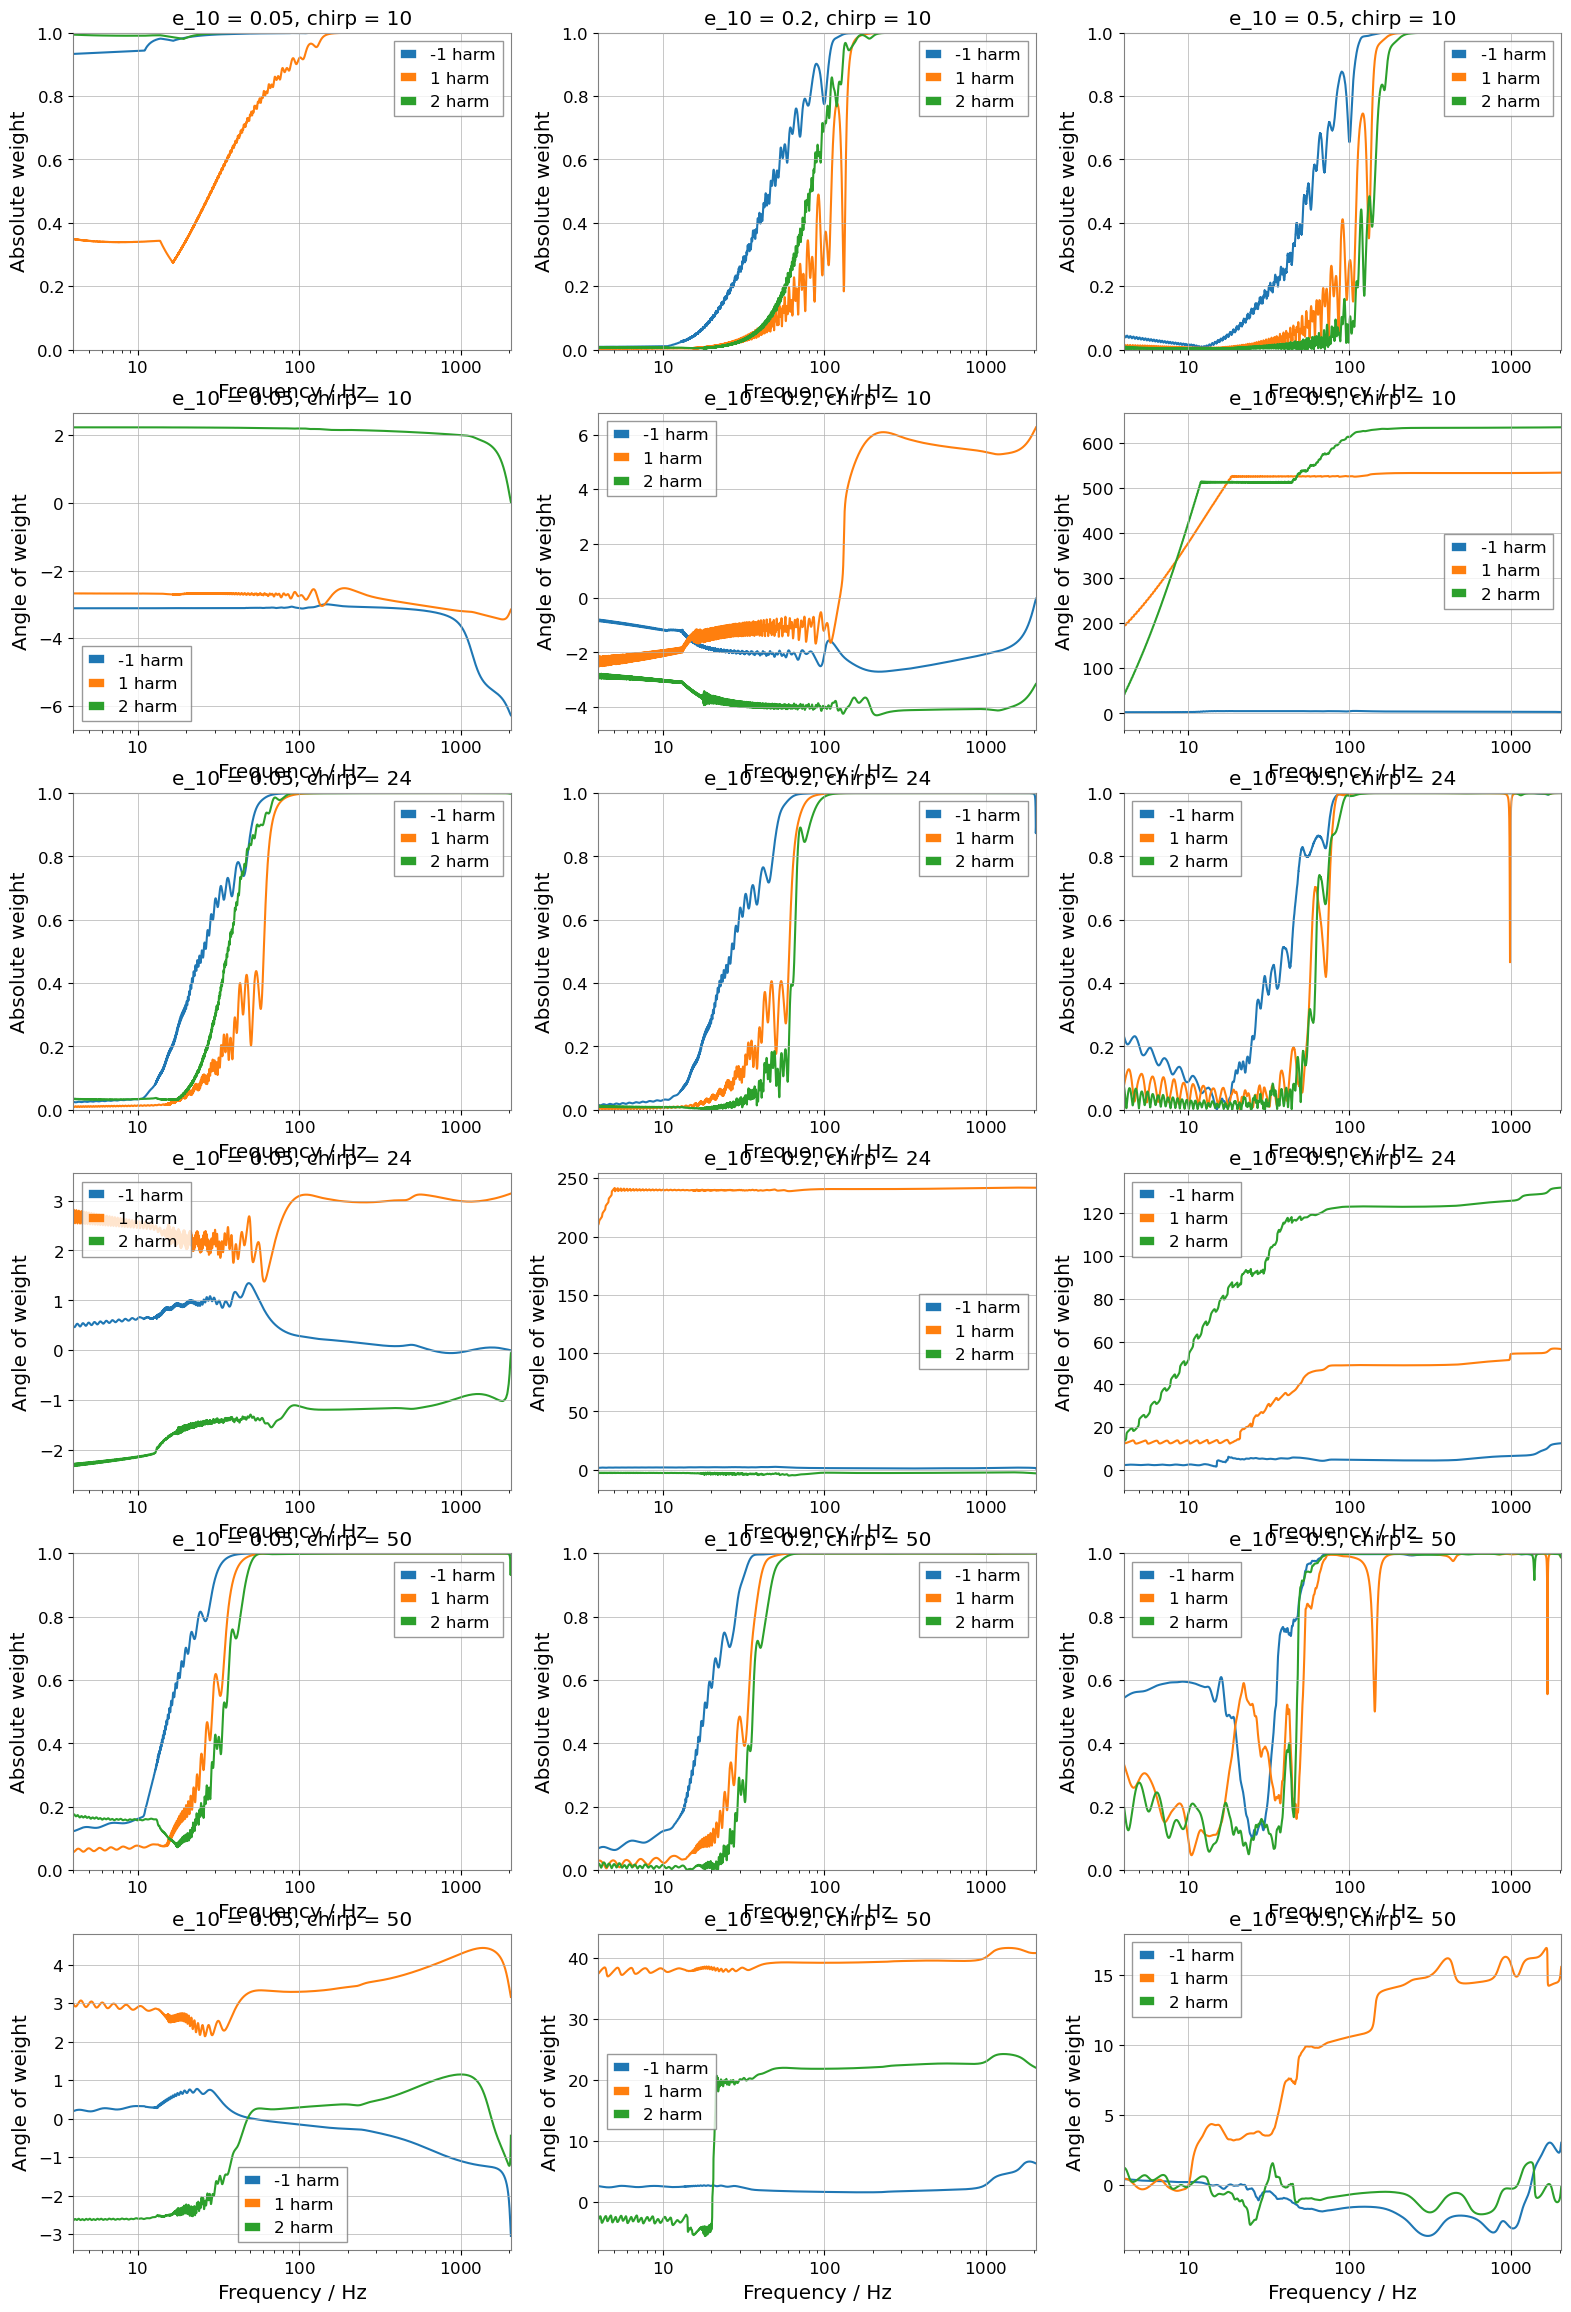

In [95]:
eccs = [0.05, 0.2, 0.5]
chirps = [10, 24, 50]
tlens = [256, 64, 16]
plt.figure(figsize=(6.4*3, 4.8*6))
for i, ecc in enumerate(eccs):
    for j, chirp in enumerate(chirps):

        # Generate harmonics
        tlen = 128
        sample_rate = 4096
        f_low = 10
        params = {'ecc10': ecc, 'chirp_mass': chirp, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
        harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)
        
        # Calculate weights at each frequency bin (for orthogonalisation with dominant harmonic only)
        freq_bin_size = 16
        N = 16*tlen+1
        weights = {}
        for k in [-1,1,2]:
            ovlp_series = harms[0].data.conj() * harms[k]
            norm_series0sqrd = np.abs(harms[0].data.conj() * harms[0])
            norm_seriesksqrd = np.abs(harms[k].data.conj() * harms[k])
            ovlp_series = np.convolve(ovlp_series, np.ones(N), mode='same')
            norm_series0 = np.sqrt(np.convolve(norm_series0sqrd, np.ones(N), mode='same'))
            norm_seriesk = np.sqrt(np.convolve(norm_seriesksqrd, np.ones(N), mode='same'))
            norm = 1 / norm_series0 / norm_seriesk
            weights[k] = ovlp_series * norm

        # Plot absolute calculated weights
        plt.subplot(6, 3, j*6+(i+1))
        for k in weights.keys():
            plt.plot(harms[0].sample_frequencies, np.abs(weights[k]), label=f'{k} harm')
        plt.legend()
        plt.ylim(0,1)
        plt.xlim(1, sample_rate/2)
        plt.xscale('log')
        plt.xlabel('Frequency / Hz')
        plt.ylabel('Absolute weight')
        plt.title(f'e_10 = {ecc}, chirp = {chirp}')

        # Plot angle of calculated weights
        plt.subplot(6, 3, j*6+(i+1)+3)
        for k in weights.keys():
            angs = np.angle(weights[k])
            ang_diffs = np.diff(angs)
            ang_diffs[ang_diffs>np.pi] -= 2*np.pi
            ang_diffs[ang_diffs<-np.pi] += 2*np.pi
            ang_diffs = np.insert(ang_diffs, 0, angs[0])
            angs = np.cumsum(ang_diffs)
            plt.plot(harms[0].sample_frequencies, angs, label=f'{k} harm')
        plt.legend()
        plt.xlim(1, sample_rate/2)
        plt.xscale('log')
        plt.xlabel('Frequency / Hz')
        plt.ylabel('Angle of weight')
        plt.title(f'e_10 = {ecc}, chirp = {chirp}')

        print(f'Calculated e_10 = {ecc}, chirp = {chirp}.')
plt.show()

Pattern is fairly consistent over all parameter combinations. For high ecc, high chirp see some weirdness likely due to such a short signal length. We also see very high overlaps for low ecc, low chirp, presumably due to the majority of the signal being quasicircular.

The phases of the weights also seem to be fairly smoothly varying so there is no problem using these.

We can now move on to trying to use these weights to orthogonalise these harmonics.

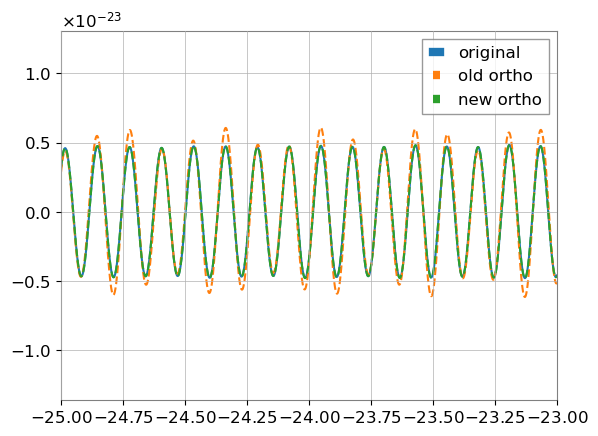

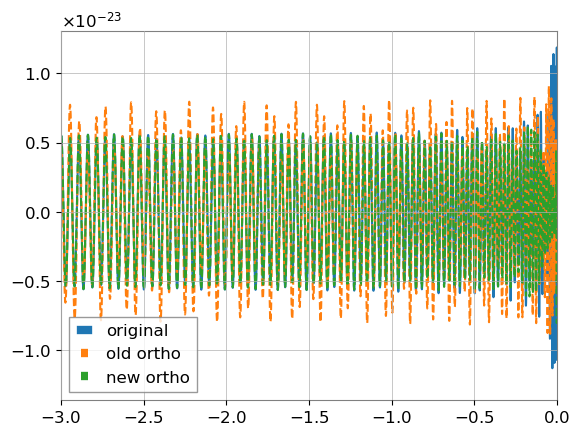

In [101]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate harmonics
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)

# Calculate weights at rolling frequency bin (for orthogonalisation with dominant harmonic only)
freq_bin_size = 16
N = int(16/harms[0].delta_f)+1
weights = {}
for k in [-1,1,2]:
    ovlp_series = harms[0].data.conj() * harms[k]
    norm_series0sqrd = np.abs(harms[0].data.conj() * harms[0])
    norm_seriesksqrd = np.abs(harms[k].data.conj() * harms[k])
    ovlp_series = np.convolve(ovlp_series, np.ones(N), mode='same')
    norm_series0 = np.sqrt(np.convolve(norm_series0sqrd, np.ones(N), mode='same'))
    norm_seriesk = np.sqrt(np.convolve(norm_seriesksqrd, np.ones(N), mode='same'))
    norm = 1 / norm_series0 / norm_seriesk
    weights[k] = ovlp_series * norm

old_ortho_harms, _, _ = old_ortho(harms, psd['H1'], 10)
h_1_perp = harms[1] - weights[1] * harms[0]
plt.plot(harms[1].to_timeseries().sample_times, harms[1].to_timeseries(), label='original')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times, old_ortho_harms[1].to_timeseries(), ls='dashed', label='old ortho')
plt.plot(h_1_perp.to_timeseries().sample_times, h_1_perp.to_timeseries(), ls='dashed', label='new ortho')
plt.xlim(-25,-23)
plt.legend()
plt.show()
plt.plot(harms[1].to_timeseries().sample_times, harms[1].to_timeseries(), label='original')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times, old_ortho_harms[1].to_timeseries(), ls='dashed', label='old ortho')
plt.plot(h_1_perp.to_timeseries().sample_times, h_1_perp.to_timeseries(), ls='dashed', label='new ortho')
plt.xlim(-3,0)
plt.legend()
plt.show()

This looks great as first sense check, as it does for other harmonics.

We should however check that these are actually orthogonal - I expect we will require some normalisation factor likely using another overlap calculation, especially as we have not yet used the psd.

In [102]:
zeta_0 = overlap_cplx(
    harms[0], harms[1], psd=psd['H1'],
    low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
    normalized=True
)
print(f'Before: {np.abs(zeta_0)}')
zeta_1 = overlap_cplx(
    harms[0], h_1_perp, psd=psd['H1'],
    low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
    normalized=True
)
print(f'After: {np.abs(zeta_1)}')

Before: 0.4500383672587292
After: 0.1451229584151894


As expected, this has not been orthogonalised, and required an normalisation factor.

Let's first use scipy.optimize.minimize to confirm that such a normalisation factor exists.

In [103]:
def min_ovlps(inds):

    h_perp_trial = harms[1] - inds[0]*np.exp(1j*inds[1]) * full_weights[1] * harms[0]
    zeta = overlap_cplx(
        harms[0], h_perp_trial, psd=psd['H1'],
        low_frequency_cutoff=10,
        high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
        normalized=True
    )
    return np.abs(zeta)

result = minimize(min_ovlps, [0.79,-0.07], bounds=((0.7,1),(-0.3,0.1)), method='Nelder-Mead')
print(result)
print(result['x'])
print(result['x'][0]*np.exp(1j*result['x'][1]))

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.4894037290487083e-05
             x: [ 8.116e-01 -1.155e-01]
           nit: 37
          nfev: 71
 final_simplex: (array([[ 8.116e-01, -1.155e-01],
                       [ 8.116e-01, -1.155e-01],
                       [ 8.117e-01, -1.156e-01]]), array([ 2.489e-05,  2.968e-05,  3.695e-05]))
[ 0.81160113 -0.11552333]
(0.8061914808565448-0.09355046006311325j)


It is able to find a complex number (approx $0.81-0.09i$) that results in an overlap of just $2\times10^{-5}$. We can therefore be reasonably sure that a suitable normalisation factor does indeed exist.

We have

$$
b_\perp (f) = b(f) - \alpha \cdot w(f) \cdot a(f),
$$

where we want to find the value of $\alpha$ such that

$$
(b_\perp (f)|a(f)) = 0.
$$

We therefore require

$$
(b(f)|a(f)) = \alpha (w(f) a(f)|a(f)),
$$

and so 

$$
\alpha = \frac{(b(f)|a(f))}{(w(f) a(f)|a(f))}
$$

In [104]:
zeta_num = overlap_cplx(
    harms[0], harms[1], psd=psd['H1'],
    low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
    normalized=True
)
print(f'Numerator: {zeta_num}')

zeta_denom = overlap_cplx(
    harms[0], full_weights[1]*harms[0], psd=psd['H1'],
    low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
    normalized=False
)
print(f'Denominator: {zeta_denom}')
alpha = zeta_num/zeta_denom
print(f'Normalisation: {alpha}')

Numerator: (-0.004004369988243126+0.45002055178169376j)
Denominator: (-0.06882662735161048+0.5501985025904371j)
Normalisation: (0.8062182771726358-0.09357516368433341j)


Note that we must make sure not to normalise the second overlap above.

In [105]:
h_1_ortho = harms[1] - alpha * full_weights[1] * harms[0]
zeta_ortho = overlap_cplx(
    harms[0], h_1_ortho, psd=psd['H1'],
    low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
    normalized=False
)
print(f'Overlap: {zeta_ortho}')

Overlap: (8.936401222135224e-18-2.298676874893456e-16j)


This is indeed the correct normalisation to ensure orthogonalisation!

What about for repeated orthogonalisation of e.g. the -1 harmonic with respect to both the dominant and 1 harmonic? Starting with

$$
c_\perp(f) = c(f) - \beta \cdot w_b (f) \cdot b_\perp(f) - \alpha \cdot w_a (f) \cdot a(f),
$$

let's choose the same form for $\alpha$ as before

$$
\alpha = \frac{(c(f)|a(f))}{(w_a(f)a(f)|a(f))},
$$

and simplify by defining a partially orthogonal $c^\prime (f)$

$$
c^\prime(f) = c(f)  - \alpha \cdot w_a (f) \cdot a(f),
$$

such that

$$
c_\perp(f) = c^\prime(f) - \beta \cdot w_b (f) \cdot b_\perp(f).
$$

We now see that $\beta$ can be found with

$$
\beta = \frac{(c^\prime(f)|b_\perp(f))}{(w_b(f)b_\perp(f)|b_\perp(f))}.
$$

This is the same as the iterative approach used in the old orthogonalisation method. We see here however that although $b_\perp(f)$ and $c_\perp(f)$ are now orthogonal, $a(f)$ and $c_\perp(f)$ are not due to the introduction of the weights causing some terms not to cancel to zero! Let's start from the beginning, without assuming a form for $\alpha$ this time.

$$
c_\perp(f) = c(f) - \beta \cdot w_b (f) \cdot b_\perp(f) - \alpha \cdot w_a (f) \cdot a(f),
$$

$$
(c_\perp(f)|a(f)) = (c(f)|a(f)) - \beta  (w_b (f) b_\perp(f)|a(f)) - \alpha (w_a (f) a(f)|a(f)) = 0,
$$

$$
(c_\perp(f)|b_\perp(f)) = (c(f)|b_\perp(f)) - \beta  (w_b (f) b_\perp(f)|b_\perp(f)) - \alpha (w_a (f) a(f)|b_\perp(f)) = 0.
$$

We now simply have two simultaneous equations we must solve in order to find consistent values of $\alpha$ and $\beta$.

$$
\alpha = \frac{(c(f)|a(f)) - \beta  (w_b (f) b_\perp(f)|a(f))}{(w_a (f) a(f)|a(f))} = \frac{(c(f)|b_\perp(f)) - \beta  (w_b (f) b_\perp(f)|b_\perp(f))}{(w_a (f) a(f)|b_\perp(f))},
$$

$$
(c(f)|a(f))(w_a (f) a(f)|b_\perp(f)) - \beta  (w_b (f) b_\perp(f)|a(f))(w_a (f) a(f)|b_\perp(f)) = (c(f)|b_\perp(f))(w_a (f) a(f)|a(f)) - \beta  (w_b (f) b_\perp(f)|b_\perp(f))(w_a (f) a(f)|a(f)),
$$

$$
\beta = \frac{(c(f)|b_\perp(f))(w_a (f) a(f)|a(f)) - (c(f)|a(f))(w_a (f) a(f)|b_\perp(f))}{(w_b (f) b_\perp(f)|b_\perp(f))(w_a (f) a(f)|a(f)) - (w_b (f) b_\perp(f)|a(f))(w_a (f) a(f)|b_\perp(f))}.
$$

Phew! Written in matrix form, we could have solved these as

\begin{equation}
\begin{pmatrix}
  (w_a (f) a(f)|a(f)) & (w_b (f) b_\perp(f)|a(f))  \\
  (w_a (f) a(f)|b_\perp(f)) &  (w_b (f) b_\perp(f)|b_\perp(f))  \\
\end{pmatrix}
\begin{pmatrix}
  \alpha \\
  \beta  \\
\end{pmatrix}
=
\begin{pmatrix}
  (c(f)|a(f)) \\
  (c(f)|b_\perp(f)) \\
\end{pmatrix},
\end{equation}

\begin{equation}
\begin{pmatrix}
  \alpha \\
  \beta  \\
\end{pmatrix}
=
\begin{pmatrix}
  (w_a (f) a(f)|a(f)) & (w_b (f) b_\perp(f)|a(f))  \\
  (w_a (f) a(f)|b_\perp(f)) &  (w_b (f) b_\perp(f)|b_\perp(f))  \\
\end{pmatrix}^{-1}
\begin{pmatrix}
  (c(f)|a(f)) \\
  (c(f)|b_\perp(f)) \\
\end{pmatrix}.
\end{equation}

This can then be easily expanded to any harmonic that needs to be orthogonalised.

Now we need to scale the orthogonalised harmonics in order to give them unit normalisation. We would ideally like to be able to do this without computing any more overlaps, like we could with the old orthogonalisation method.

Let's start from

$$
(b_\perp(f)|b_\perp(f)) = \gamma,
$$

which gives us

$$
(b(f)|b(f)) + \alpha^2 (w(f)a(f)|w(f)a(f)) - \alpha \left[ (b(f)|w(f)a(f)) + (w(f)a(f)|b(f)) \right] = \gamma.
$$

Already at this stage this requires the computation of overlaps which we have not yet evaluated. It is therefore most efficient to simply calculate the normalise the final orthogonal harmonic directly. Let's once more plot this in comparison to the original harmonic and old orthogonalised version for comparison.

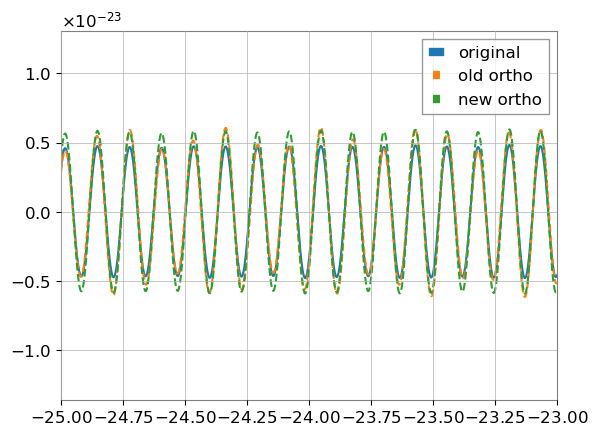

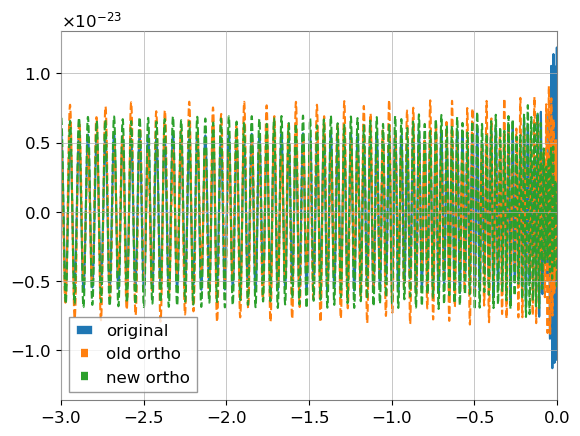

In [106]:
h_1_ortho = harms[1] - alpha * full_weights[1] * harms[0]
sig = sigma(h_1_ortho, psd['H1'], low_frequency_cutoff=10,
      high_frequency_cutoff=psd['H1'].sample_frequencies[-1])
h_1_ortho /= sig
old_ortho_harms, _, _ = old_ortho(harms, psd['H1'], 10)
plt.plot(harms[1].to_timeseries().sample_times, harms[1].to_timeseries(), label='original')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times, old_ortho_harms[1].to_timeseries(), ls='dashed', label='old ortho')
plt.plot(h_1_ortho.to_timeseries().sample_times, h_1_ortho.to_timeseries(), ls='dashed', label='new ortho')
plt.xlim(-25,-23)
plt.legend()
plt.show()
plt.plot(harms[1].to_timeseries().sample_times, harms[1].to_timeseries(), label='original')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times, old_ortho_harms[1].to_timeseries(), ls='dashed', label='old ortho')
plt.plot(h_1_ortho.to_timeseries().sample_times, h_1_ortho.to_timeseries(), ls='dashed', label='new ortho')
plt.xlim(-3,0)
plt.legend()
plt.show()

Let's examine merger specifically, where we had the most trouble before.

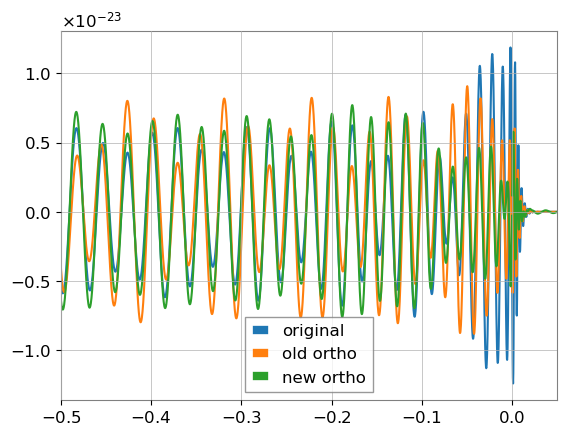

In [107]:
plt.plot(harms[1].to_timeseries().sample_times, harms[1].to_timeseries(), c='C0', label='original')
plt.plot(harms[1].to_timeseries().sample_times+32, harms[1].to_timeseries(), c='C0')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times, old_ortho_harms[1].to_timeseries(), c='C1', label='old ortho')
plt.plot(old_ortho_harms[1].to_timeseries().sample_times+32, old_ortho_harms[1].to_timeseries(), c='C1')
plt.plot(h_1_ortho.to_timeseries().sample_times, h_1_ortho.to_timeseries(), c='C2', label='new ortho')
plt.plot(h_1_ortho.to_timeseries().sample_times+32, h_1_ortho.to_timeseries(), c='C2')
plt.xlim(-0.5,0.05)
plt.legend()
plt.show()

The only slight area I can see where this is not an outright improvement is the ringdown/post-signal, which seems to have some noise introduced in the new orthogonalisation method. I assume this is due to it being at the same frequency as part of the inspiral. This is however at very little power and so I do not expect it to have any significant effect when considering the entire waveform.

We can now finally create a new orthonormalisation function capable of using this new method to orthonormalise an entire set of harmonics.

In [227]:
def new_ortho(h, ifo_psd, f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1]):

    # Ensure modes in ortho_list are orthogonalized first
    modes = np.concatenate((ortho_list, modes))
    modes = list(dict.fromkeys(modes))

    sigmas = {}
    for mode in modes:

        try:
            sigmas[mode] = sigma(
                h[mode], ifo_psd, low_frequency_cutoff=f_low,
                high_frequency_cutoff=ifo_psd.sample_frequencies[-1]
                )
            h[mode] /= sigmas[mode]
        except ZeroDivisionError:
            print("No power in mode %s" % mode)
            h.pop(mode)

    zetas = {ortho_list[0]: 1}
    h_perp = {}
    freq_bin_size = 16
    N = int(16/harms[0].delta_f)+1
    norm_series = {}
    for mode in modes:
        h_perp[mode] = h[mode].copy()
        weight_list = []
        weight_matrix_T = []
        ovlp_matrix = []
        norm_series_sqrd = harms[mode].data.conj() * harms[mode]
        norm_series[mode] = np.sqrt(np.abs(N*uniform_filter1d(
            norm_series_sqrd, size=N, mode='constant', cval=0
        )))
        for ortho_mode in ortho_list:
            if mode == ortho_mode:
                break

            # Calculate weights
            ovlp_series = harms[ortho_mode].data.conj() * harms[mode]
            ovlp_series_avg = N*uniform_filter1d(
                ovlp_series, size=N, mode='constant', cval=0
            )
            norm = 1 / norm_series[ortho_mode] / norm_series[mode]
            weight_list.append(ovlp_series_avg * norm)

            # Calculate overlap matrix element
            ovlp_elmnt = overlap_cplx(
                h_perp[ortho_mode], h_perp[mode], psd=ifo_psd,
                low_frequency_cutoff=f_low,
                high_frequency_cutoff=ifo_psd.sample_frequencies[-1],
                normalized=False
            )
            ovlp_matrix.append(ovlp_elmnt)
            if ortho_mode == ortho_list[0]:
                zetas[mode] = ovlp_elmnt

            # Calculate weight matrix column
            column = []
            for _ortho_mode in ortho_list:
                if mode == _ortho_mode:
                    break
                column_elmnt = overlap_cplx(
                    h_perp[_ortho_mode], weight_list[-1]*h_perp[ortho_mode],
                    psd=ifo_psd, low_frequency_cutoff=f_low,
                    high_frequency_cutoff=ifo_psd.sample_frequencies[-1],
                    normalized=False
                )
                column.append(column_elmnt)
            weight_matrix_T.append(column)

        # Orthogonalise and normalise
        if mode != ortho_list[0]:
            weight_matrix = np.array(weight_matrix_T).T
            ortho_coeffs = np.linalg.inv(weight_matrix).dot(ovlp_matrix)
            for i in range(len(ortho_coeffs)):
                h_perp[mode] -= ortho_coeffs[i] * weight_list[i] * h_perp[ortho_list[i]]
            h_perp[mode] /= sigma(
                h_perp[mode], ifo_psd, low_frequency_cutoff=f_low,
                high_frequency_cutoff=ifo_psd.sample_frequencies[-1]
            )

    return h_perp, sigmas, zetas

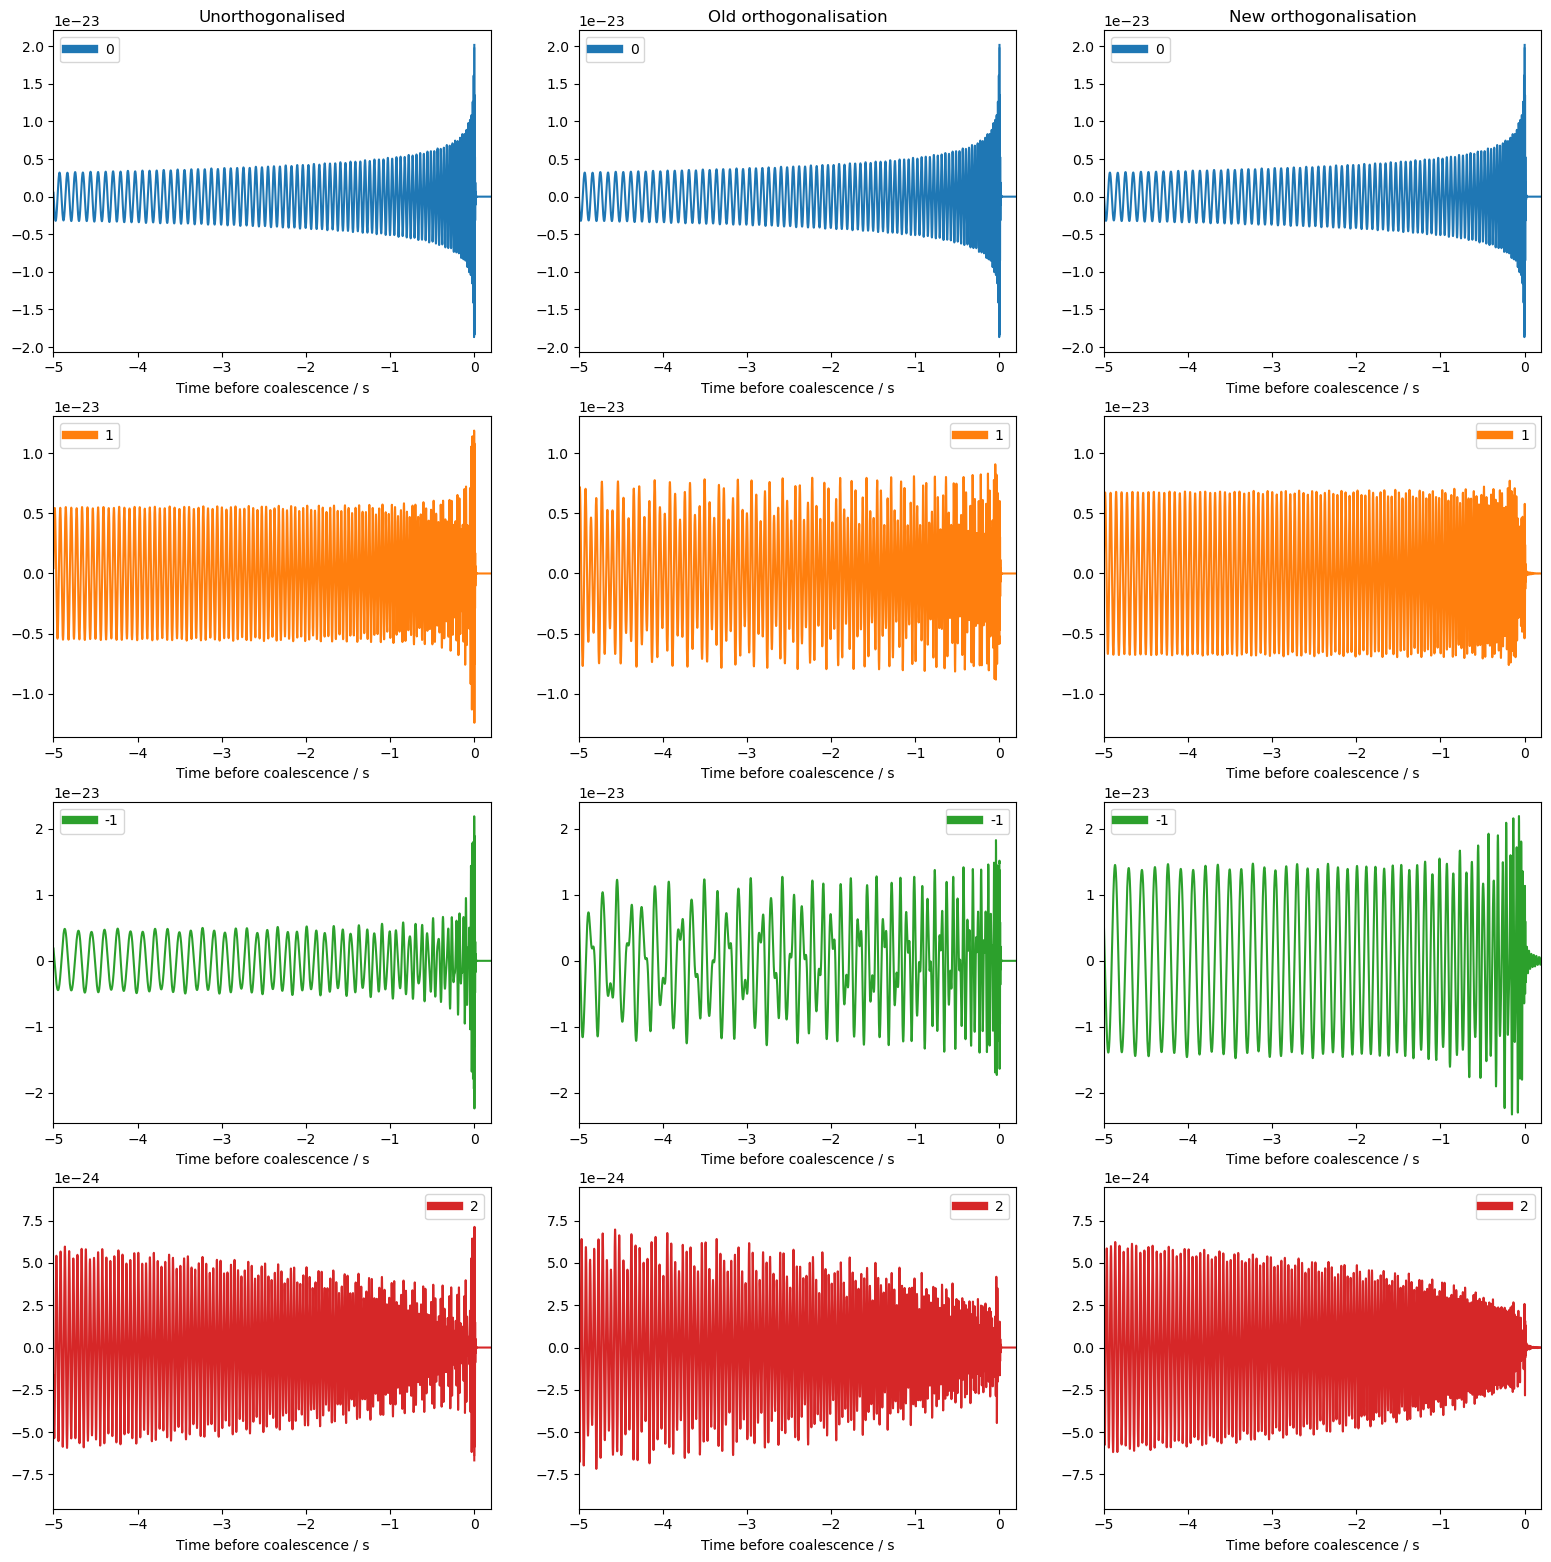

In [228]:
# Generate psd
ifos = ['H1']
tlen = 64
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate harmonics
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)

# Orthogonalise and plot
new_ortho_harms, _, _ = new_ortho(harms, psd['H1'], 10, ortho_list=[0,1,-1])
old_ortho_harms, _, _ = old_ortho(harms, psd['H1'], 10, ortho_list=[0,1,-1])
plt.figure(figsize=(6.4*3,4.8*len(new_ortho_harms.keys())))
for i, k in enumerate(new_ortho_harms.keys()):
    plt.subplot(len(new_ortho_harms.keys()),3,3*(i)+1)
    plt.plot(harms[k].to_timeseries().sample_times, harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(harms[k].to_timeseries().sample_times+tlen, harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('Unorthogonalised')
    plt.legend()
    ylim = plt.gca().get_ylim()
    plt.subplot(len(new_ortho_harms.keys()),3,3*(i)+2)
    plt.plot(old_ortho_harms[k].to_timeseries().sample_times, old_ortho_harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(old_ortho_harms[k].to_timeseries().sample_times+tlen, old_ortho_harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.ylim(ylim)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('Old orthogonalisation')
    plt.legend()
    plt.subplot(len(new_ortho_harms.keys()),3,3*(i)+3)
    plt.plot(new_ortho_harms[k].to_timeseries().sample_times, new_ortho_harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(new_ortho_harms[k].to_timeseries().sample_times+tlen, new_ortho_harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.ylim(ylim)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('New orthogonalisation')
    plt.legend()
plt.show()

In [229]:
# Check all harmonics are orthogonal
keys = list(new_ortho_harms.keys())
for i in range(len(keys)):
    for j in range(i+1,len(keys)):
        zeta = overlap_cplx(
                    new_ortho_harms[keys[i]], new_ortho_harms[keys[j]],
                    psd=psd['H1'], low_frequency_cutoff=10,
                    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
                    normalized=True
                )
        print(f'{keys[i]} with {keys[j]}: {np.abs(zeta):.3g}')

0 with 1: 5.06e-17
0 with -1: 4.61e-16
0 with 2: 1.11e-16
1 with -1: 5.9e-17
1 with 2: 1.1e-16
-1 with 2: 5.89e-17


In [230]:
from simple_pe.waveforms import calculate_mode_snr

# Make wf at same parameters
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
wf = make_waveform(params, 1/64, 5, (64*4096)//2 + 1, approximant='TEOBResumS-Dali')
total_snr = 20
sig = sigma(
    wf, psd['H1'], low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1]
)
wf *= total_snr/sig

# Calculate snrs using old orthogonalisation
ts = wf.to_timeseries().sample_times
t_start = ts[0]
t_end = ts[-1]
old_snrs, _ = calculate_mode_snr(
    wf, psd['H1'], old_ortho_harms, t_start, t_end, 10, [0,1,-1,2],
    subsample_interpolation=True, dominant_mode=0
)
print('Old orthogonalisation method:')
total_old_snr_sqrd = 0
for k in old_snrs.keys():
    print(f'rho_{k} = {np.abs(old_snrs[k]):.3f}, phi_{k} = {np.angle(old_snrs[k]):.2f}')
    total_old_snr_sqrd += np.abs(old_snrs[k])**2
print(f'Total: {np.sqrt(total_old_snr_sqrd):.3f}')

# Calculate snrs using new orthogonalisation
new_snrs, _ = calculate_mode_snr(
    wf, psd['H1'], new_ortho_harms, t_start, t_end, 10, [0,1,-1,2],
    subsample_interpolation=True, dominant_mode=0
)
print('\nNew orthogonalisation method:')
total_new_snr_sqrd = 0
for k in new_snrs.keys():
    print(f'rho_{k} = {np.abs(new_snrs[k]):.3f}, phi_{k} = {np.angle(new_snrs[k]):.2f}')
    total_new_snr_sqrd += np.abs(new_snrs[k])**2
print(f'Total: {np.sqrt(total_new_snr_sqrd):.3f}')

Old orthogonalisation method:
rho_0 = 19.094, phi_0 = 0.22
rho_1 = 5.021, phi_1 = 0.03
rho_-1 = 1.628, phi_-1 = -0.14
rho_2 = 1.854, phi_2 = 0.05
Total: 19.897

New orthogonalisation method:
rho_0 = 19.094, phi_0 = 0.22
rho_1 = 4.557, phi_1 = 0.01
rho_-1 = 1.809, phi_-1 = -0.27
rho_2 = 1.831, phi_2 = 0.07
Total: 19.799


Let's also test the speed of the new method compared to the old one. We are computing more overlaps now so we should expect it to be slower.

In [231]:
import time

n_loops = 5

start = time.time()
for i in range(n_loops):
    _ = old_ortho(harms, psd['H1'], 10, modes=[0,1,-1], ortho_list=[0,1])
end = time.time()
print(f'Old method takes {(end-start)/n_loops} seconds per call.')

start = time.time()
for i in range(n_loops):
    _ = new_ortho(harms, psd['H1'], 10, modes=[0,1,-1], ortho_list=[0,1])
end = time.time()
print(f'New method takes {(end-start)/n_loops} seconds per call.')

Old method takes 0.07408761978149414 seconds per call.
New method takes 0.1273561954498291 seconds per call.


# Test simple-pe implementation

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter import overlap_cplx, sigma
from pycbc import psd as psd_func
from simple_pe.waveforms import orthonormalize_modes, make_waveform, calculate_mode_snr

In [6]:
# Generate psd
ifos = ['H1']
tlen = 64
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate harmonics
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)

# Orthonormalize
uw_harms, _, _ = orthonormalize_modes(harms, psd['H1'], f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1])
w_harms, _, _ = orthonormalize_modes(harms, psd['H1'], f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1], use_weights=True)

2025-12-08  14:05:38 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-12-08  14:05:38 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


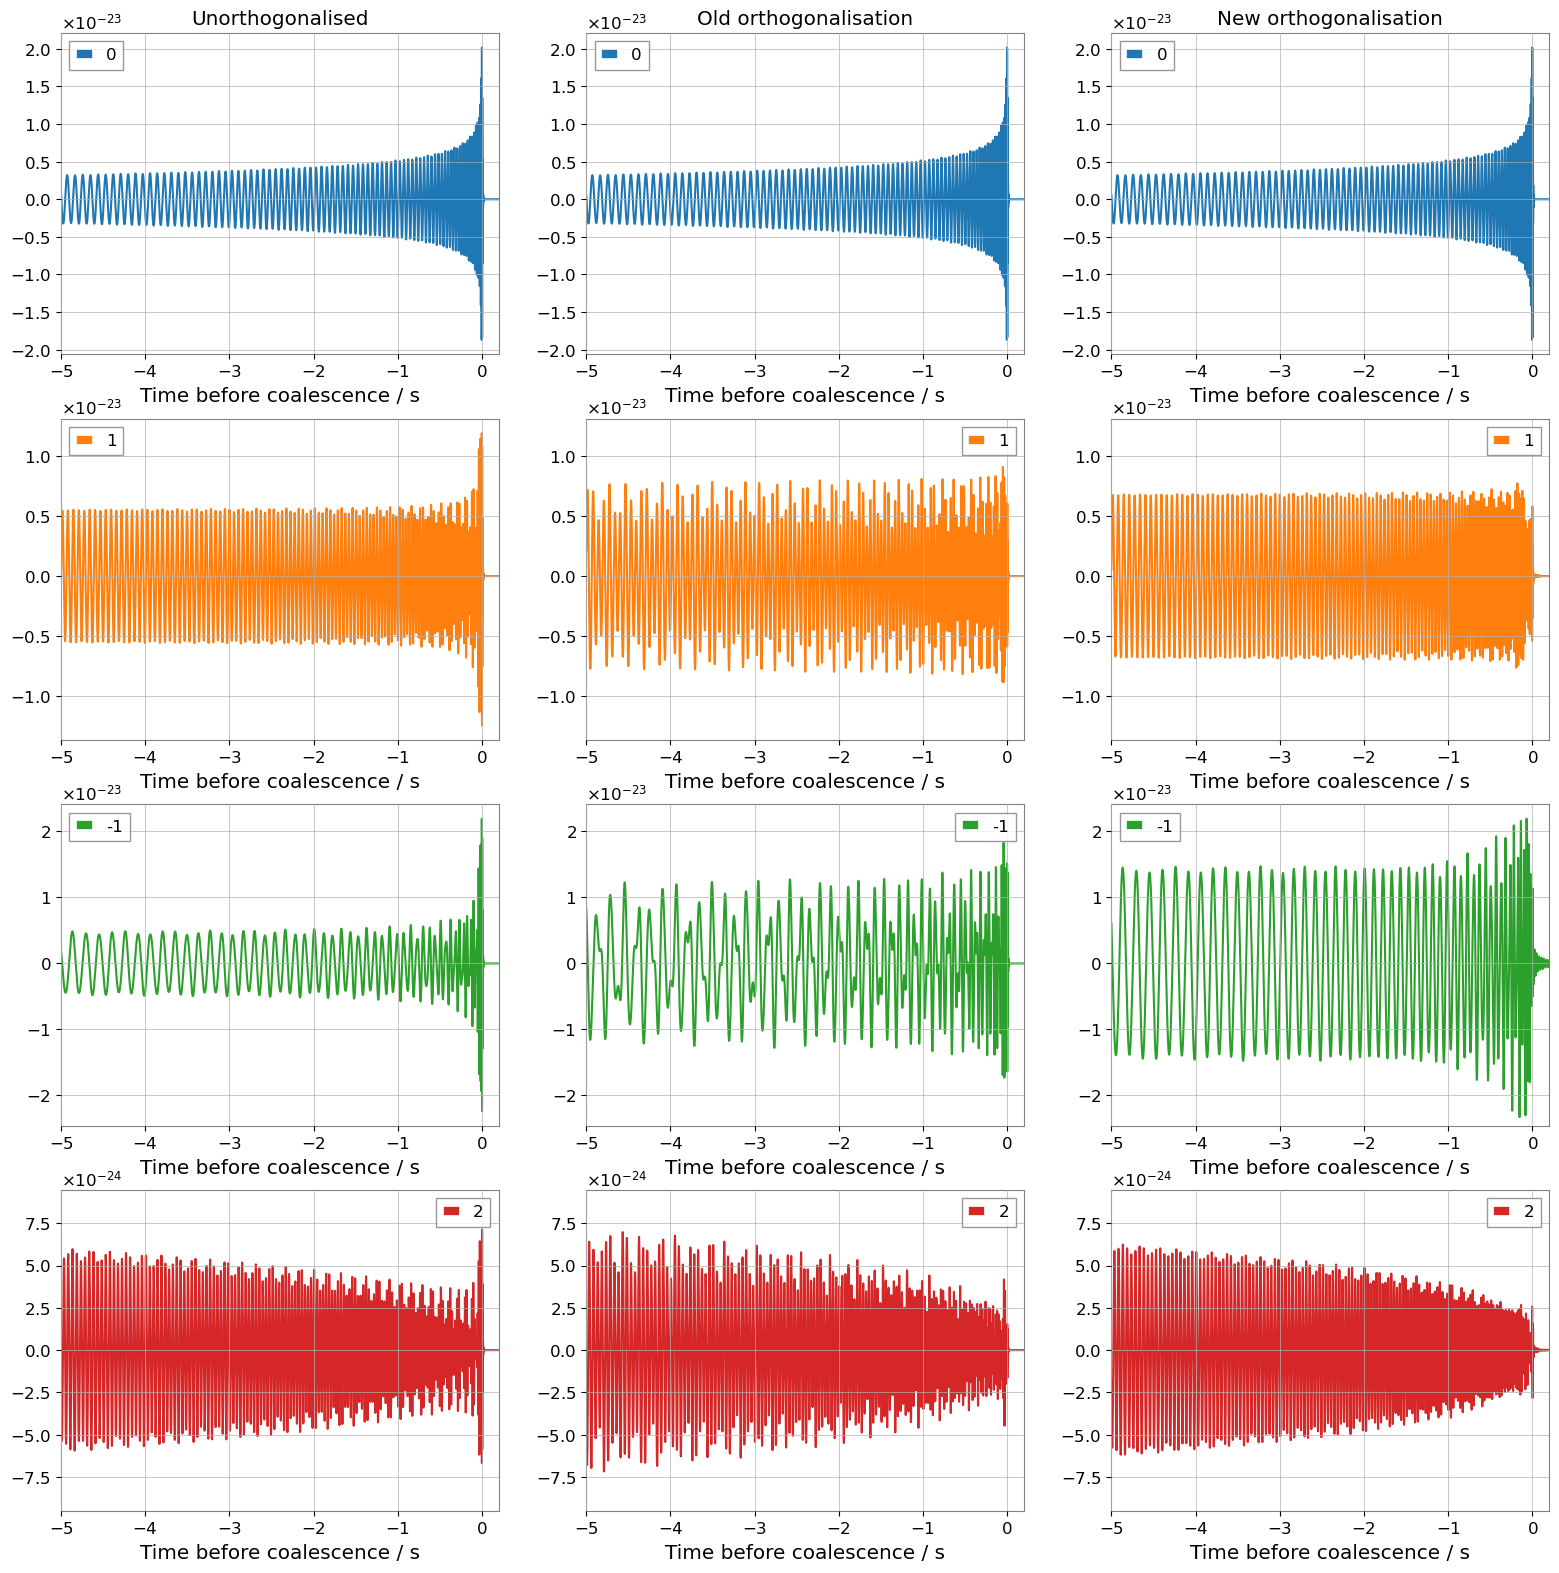

In [7]:
# Orthogonalise and plot
plt.figure(figsize=(6.4*3,4.8*len(w_harms.keys())))
for i, k in enumerate(w_harms.keys()):
    plt.subplot(len(w_harms.keys()),3,3*(i)+1)
    plt.plot(harms[k].to_timeseries().sample_times, harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(harms[k].to_timeseries().sample_times+tlen, harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('Unorthogonalised')
    plt.legend()
    ylim = plt.gca().get_ylim()
    plt.subplot(len(w_harms.keys()),3,3*(i)+2)
    plt.plot(uw_harms[k].to_timeseries().sample_times, uw_harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(uw_harms[k].to_timeseries().sample_times+tlen, uw_harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.ylim(ylim)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('Old orthogonalisation')
    plt.legend()
    plt.subplot(len(w_harms.keys()),3,3*(i)+3)
    plt.plot(w_harms[k].to_timeseries().sample_times, w_harms[k].to_timeseries(), c=f'C{i}', label=str(k))
    plt.plot(w_harms[k].to_timeseries().sample_times+tlen, w_harms[k].to_timeseries(), c=f'C{i}')
    plt.xlim(-5, 0.2)
    plt.ylim(ylim)
    plt.xlabel('Time before coalescence / s')
    if i == 0:
        plt.title('New orthogonalisation')
    plt.legend()
plt.show()

In [10]:
# Check all harmonics are orthogonal
print('')
keys = list(uw_harms.keys())
for i in range(len(keys)):
    for j in range(i+1,len(keys)):
        zeta = overlap_cplx(
                    uw_harms[keys[i]], uw_harms[keys[j]],
                    psd=psd['H1'], low_frequency_cutoff=10,
                    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
                    normalized=True
                )
        print(f'{keys[i]} with {keys[j]}: {np.abs(zeta):.3g}')

# Check all harmonics are orthogonal
keys = list(w_harms.keys())
for i in range(len(keys)):
    for j in range(i+1,len(keys)):
        zeta = overlap_cplx(
                    w_harms[keys[i]], w_harms[keys[j]],
                    psd=psd['H1'], low_frequency_cutoff=10,
                    high_frequency_cutoff=psd['H1'].sample_frequencies[-1],
                    normalized=True
                )
        print(f'{keys[i]} with {keys[j]}: {np.abs(zeta):.3g}')


0 with 1: 7.63e-17
0 with -1: 1.01e-16
0 with 2: 1.34e-17
1 with -1: 4.31e-17
1 with 2: 1.21e-16
-1 with 2: 4e-17
0 with 1: 1.93e-16
0 with -1: 5.71e-16
0 with 2: 1.85e-17
1 with -1: 5.34e-17
1 with 2: 8.55e-17
-1 with 2: 2.33e-17


In [14]:
# Make wf at same parameters
params = {'ecc10': 0.21, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
wf = make_waveform(params, 1/64, 5, (64*4096)//2 + 1, approximant='TEOBResumS-Dali')
total_snr = 20
sig = sigma(
    wf, psd['H1'], low_frequency_cutoff=10,
    high_frequency_cutoff=psd['H1'].sample_frequencies[-1]
)
wf *= total_snr/sig

# Calculate snrs using old orthogonalisation
ts = wf.to_timeseries().sample_times
t_start = ts[0]
t_end = ts[-1]
old_snrs, _ = calculate_mode_snr(
    wf, psd['H1'], uw_harms, t_start, t_end, 10, [0,1,-1,2],
    subsample_interpolation=True, dominant_mode=0
)
print('Old orthogonalisation method:')
total_old_snr_sqrd = 0
for k in old_snrs.keys():
    print(f'rho_{k} = {np.abs(old_snrs[k]):.3f}, phi_{k} = {np.angle(old_snrs[k]):.2f}')
    total_old_snr_sqrd += np.abs(old_snrs[k])**2
print(f'Total: {np.sqrt(total_old_snr_sqrd):.3f}')

# Calculate snrs using new orthogonalisation
new_snrs, _ = calculate_mode_snr(
    wf, psd['H1'], w_harms, t_start, t_end, 10, [0,1,-1,2],
    subsample_interpolation=True, dominant_mode=0
)
print('\nNew orthogonalisation method:')
total_new_snr_sqrd = 0
for k in new_snrs.keys():
    print(f'rho_{k} = {np.abs(new_snrs[k]):.3f}, phi_{k} = {np.angle(new_snrs[k]):.2f}')
    total_new_snr_sqrd += np.abs(new_snrs[k])**2
print(f'Total: {np.sqrt(total_new_snr_sqrd):.3f}')

2025-12-08  14:08:44 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-12-08  14:08:44 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


Old orthogonalisation method:
rho_0 = 19.040, phi_0 = 1.76
rho_1 = 4.190, phi_1 = -0.74
rho_-1 = 1.897, phi_-1 = -1.70
rho_2 = 0.855, phi_2 = -2.77
Total: 19.607

New orthogonalisation method:
rho_0 = 19.040, phi_0 = 1.76
rho_1 = 3.650, phi_1 = -0.74
rho_-1 = 1.625, phi_-1 = -1.69
rho_2 = 0.494, phi_2 = -2.83
Total: 19.461


In [17]:
n_loops = 10
start = time.time()
for i in range(n_loops):
    _ = orthonormalize_modes(harms, psd['H1'], 10, modes=[0,1,-1], ortho_list=[0,1])
end = time.time()
print(f'Old method takes {(end-start)/n_loops} seconds per call.')

start = time.time()
for i in range(n_loops):
    _ = orthonormalize_modes(harms, psd['H1'], 10, modes=[0,1,-1], ortho_list=[0,1], use_weights=True)
end = time.time()
print(f'New method takes {(end-start)/n_loops} seconds per call.')

Old method takes 0.09601936340332032 seconds per call.
New method takes 0.20187730789184571 seconds per call.
